# EP02 - Parte 1 - Visão e processamento de imagens

Integrantes: 

- Bruna Lobato - 10666972
- Felipe Noronha - 10737032
- Izabela Fonsceca - 11583721

---

## 1. Introdução

Você pode conferir a entrega anterior e todas as imagens que constituem a base de dados no [GitHub do projeto](https://github.com/fcnoronha/visao-e-prcessamento-de-imagens).

Esse Jupyter Notebook representa a Parte 1 desta tarefa, que consiste em realizar **data augmentation** do dataset original. Para isso, vamos criar 2 novos datasets, são eles:

- `original-gray`: consiste de todas as imagens do dataset original (chamado de `raw`) convertidas de RGB para niveis de cinza.
- `augmented`: consiste das imagens originais (coloridas) e as do dataset `original-gray` onde, para cada imagem, além de sua cópia, teremos mais 4 variantes da mesma, cada uma sendo uma aplicação das funções abaixo:
    - Soma de fundo com gradiente de níveis de cinza;
    - Logaritmo da imagem;
    - Exponencial da imagem;
    - Filtro da média implementado usando convolução.

Para isso, utilizaremos metodos do pacote `scikit-image` e `scipy`.

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import random

from PIL import ImageOps, Image
from scipy import ndimage

from skimage.exposure import adjust_log, rescale_intensity
from skimage.util import img_as_ubyte
from skimage.color import rgb2gray
from skimage import io, img_as_float64

# caminhos para os datasets
RAW_PATH = 'datasets/raw/'
GRAY_PATH = 'datasets/original-gray/'
AUG_PATH = 'datasets/augmented/'

## 2. Importanto a base da dados

Os blocos a seguir podem ser usados para importar a base de dados.

In [ ]:
# monta arquivos a partir do Github

# !rm -rf tmp imagens
# !git clone --depth 1 https://github.com/fcnoronha/visao-e-prcessamento-de-imagens tmp
# !mv -v tmp/datasets .

## 3. Niveis de cinza

Abaixo, utilizamos a função [`rgb2gray`](https://scikit-image.org/docs/dev/api/skimage.color.html#skimage.color.rgb2gray) para criar o dataset `original-gray`, que consiste das imagens do dataset `raw` (i.e. imagens coloridas) transformadas em imagens em escala de cinza.

In [2]:
for path, dirs, files in os.walk(RAW_PATH):
    for file in files:
        image_path = os.path.join(path, file)
        img = io.imread(image_path)
        img_gray = rgb2gray(img)
        io.imsave(GRAY_PATH + file, img_as_ubyte(img_gray), quality=100)

## 4. Augmented dataset

Aqui, vamos construir do _augmented dataset_, explicando o que é feito em cada etapa.

### 4.0 Imagens originais

A primeira parte consiste em pegarmos todas as imagens originais/coloridas.

In [3]:
for path, dirs, files in os.walk(RAW_PATH):
    for file in files:
        
        image_name = file[:-4]
        image_path = os.path.join(path, file)
        image = io.imread(image_path)

        io.imsave(AUG_PATH + image_name + '_col.jpg', img_as_ubyte(image), quality=100, check_contrast=False)

### 4.1 Imagens em escala de cinza

Agora, pegamos as imagens em escala de cinza.

In [4]:
for path, dirs, files in os.walk(GRAY_PATH):
    for file in files:
        
        image_name = file[:-4]
        image_path = os.path.join(path, file)
        image = io.imread(image_path, as_gray=True)

        io.imsave(AUG_PATH + image_name + '_gray.jpg', img_as_ubyte(image), quality=100, check_contrast=False)

### 4.2 Soma de fundo com gradiente de níveis de cinza

Agora, usando o `numpy`, geramos uma matriz em que seus numeros represetam um gradinte, isto é, um _linear space_ no eixo $y$. Após isso, fazemos a média pixel a pixel deste gradiente com a imagem original. 

Decimos tirar a média devido ao fato de que simplesmente a soma estava fazendo com que boa parte da imagem ficasse saturada.

In [5]:
for path, dirs, files in os.walk(GRAY_PATH):
    for file in files:

        image_name = file[:-4]
        image_path = os.path.join(path, file)
        image = io.imread(image_path, as_gray=True)

        # generating gradient
        height, width = image.shape
        gradient = np.tile(np.linspace(0, 1, height), (width, 1)).T*255
        
        # pixel-pixel mean between image and gradient
        image_grad = ((image + gradient) / 2).astype(np.uint8)
        
        io.imsave(AUG_PATH + image_name + '_grad.jpg', img_as_ubyte(image_grad), quality=100, check_contrast=False)

### 4.3 Logaritmo da imagem

Usando o método [`adjust_log`](https://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.adjust_log) do `skimage`, aplicamos uma correção logaritmica na imagem.

In [6]:
for path, dirs, files in os.walk(GRAY_PATH):
    for file in files:
        
        image_name = file[:-4]
        image_path = os.path.join(path, file)
        image = io.imread(image_path, as_gray=True)

        image_log = adjust_log(image, inv=False)
        io.imsave(AUG_PATH + image_name + '_log.jpg', img_as_ubyte(image_log), quality=100, check_contrast=False)

### 4.4 Exponencial da imagem

Similarmente ao item acima, usamos o método [`adjust_log`](https://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.adjust_log), porém, agora com o parametro `inv=True`, que aplica a correção com a função log inverso, ou seja, exponencial.

In [7]:
for path, dirs, files in os.walk(GRAY_PATH):
    for file in files:

        image_name = file[:-4]
        image_path = os.path.join(path, file)
        image = io.imread(image_path, as_gray=True)

        image_exp = adjust_log(image, inv=True) # inverse logarithmic correction
        io.imsave(AUG_PATH + image_name + '_exp.jpg', img_as_ubyte(image_exp), quality=100, check_contrast=False)

### 4.5 Filtro da média implementado usando convolução

Finalmente, usamos o metodo [`convolve`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.convolve.html) do `scipy` para aplicar uma convolução utilizando um kenel $5 \times 5$ com valores $\frac{1}{25}$, ou seja, aplicando um filtro de média com tamanho 5.

Note que tivemos que converter a imagem para float, para então podemos usar a convolução. Além disso, devido alguns problemas com precisão com o método `img_as_ubyte`, utilizamos o método `rescale_intensity` para forçar que os valores ficassem no intervalo $[-1,1]$.

In [20]:
for path, dirs, files in os.walk(GRAY_PATH):
    for file in files:

        image_name = file[:-4]
        image_path = os.path.join(path, file)
        image = io.imread(image_path, as_gray=True)
        image_f = img_as_float64(image)

        kernel = np.ones((5, 5))/25

        # 'constant' mode fill values beyond edge with 'cval'
        image_mean = ndimage.convolve(image_f, kernel, mode='constant', cval=0.0)
        image_mean = rescale_intensity(image_mean, out_range='float') # force float values to be in [-1, 1]

        io.imsave(AUG_PATH + image_name + '_mean.jpg', img_as_ubyte(image_mean), quality=100, check_contrast=False)

## 5. Visualização da base

Abaixo, visualizamos algumas imagens do dataset `augmented`.

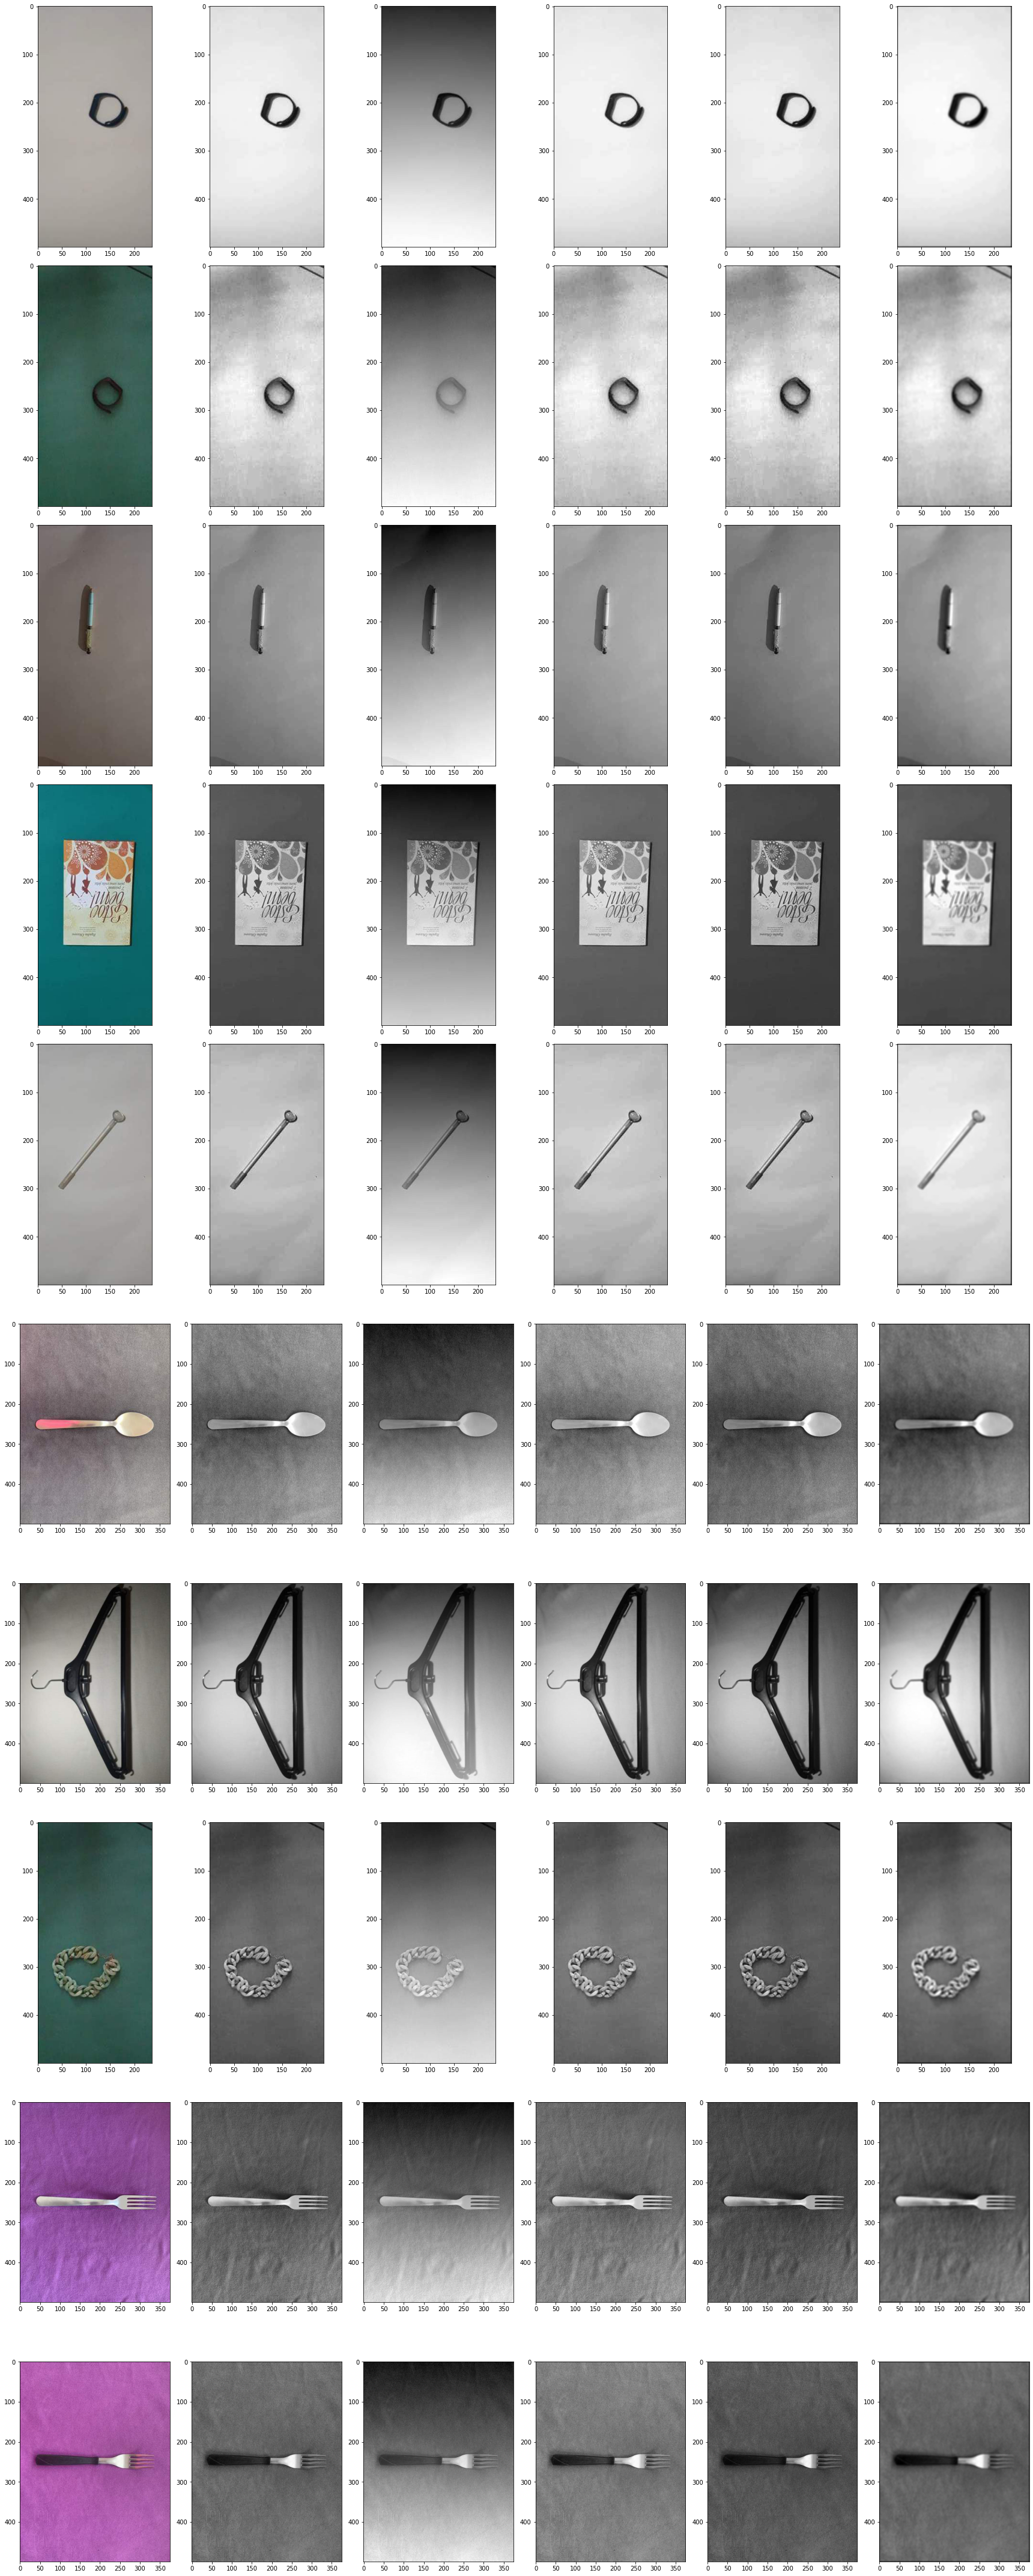

In [21]:
num_row = 10
num_col = 6

images_names = []
for path, dirs, files in os.walk(GRAY_PATH):
    for file in files:
        images_names.append(file)

images = []
suffixes = ['_col', '_gray', '_grad', '_log', '_exp', '_mean']
for img in random.sample(images_names, num_row):
    for s in suffixes:
        path = AUG_PATH + img[:-4] + s + '.jpg'
        images.append(io.imread(path))

fig, axes = plt.subplots(num_row, num_col, figsize=(4*num_col, 6*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')

plt.tight_layout()
plt.show()